In [1]:
### Distributed Glowworm Optimization Scheme
### Wiki: https://en.wikipedia.org/wiki/Glowworm_swarm_optimization
import numpy as np
import matplotlib.pyplot as plt
import simpy
import random

In [2]:
##############################################################################
# GSO PARAMETERS 
##############################################################################
dims = 1000
num_worms = 25
nturns = 2000
max_jitter = 0.2

In [45]:
##############################################################################
# Fitness Function 
##############################################################################
def Easom(x,y):
    return np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

# def fitness_function(xx,yy): # one target
#     x = xx/200 + 1.5
#     y = yy/200 + 1.5
#     return np.cos(x) * np.cos(y) * np.exp(-((x - np.pi)**2 + (y - np.pi)**2))

# def fitness_function(xx, yy): # two targets
#     x = xx/200
#     y = yy/200
#     return 16 - ((x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73))

# def fitness_function(xx,yy): # three target
#     x1 = xx/200 - 0.5
#     y1 = yy/200 - 0.5
#     z1 = Easom(x1,y1)
#     x2 = xx/200 + 1.5
#     y2 = yy/200 + 1.9
#     z2 = Easom(x2,y2)
#     x3 = xx/180 + 2
#     y3 = yy/180 - 1
#     z3 = Easom(x3,y3)
#     return z1 + 0.8 * z2 + 0.7 * z3

# def fitness_function(xx, yy): # four targets
#     x = xx/120 - 4
#     y = yy/120 - 4
#     return 6 - np.log((x**2 + y - 11)**2 + (x + y**2 -7)**2)

def fitness_function(x, y): # Three-Hump Camel
    x1 = x/180 - 2.9
    x2 = y/180 - 2.9
    # The formula for the Three-Hump Camel function
    f_x = np.log(2 * x1**2 - 1.05 * x1**4 + (x1**6) / 6 + x1 * x2 + x2**2)
    return (5-f_x)/10

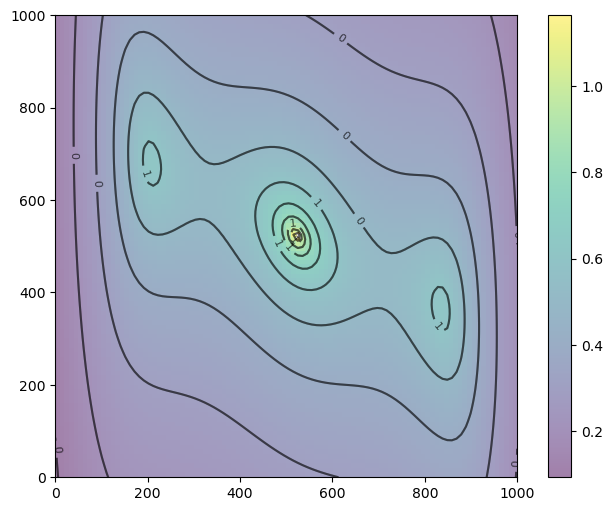

In [46]:
# Plotting - no Animation
x, y = np.array(np.meshgrid(np.linspace(0, dims, 100), np.linspace(0, dims, 100)))
z = fitness_function(x, y)
x_max, y_max = x.ravel()[z.argmax()], y.ravel()[z.argmax()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_max], [y_max], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.show()



In [85]:
##############################################################################
# Min Max of the fitness function
##############################################################################
x, y = np.array(np.meshgrid(np.linspace(0, dims, dims), np.linspace(0, dims, dims)))
z = fitness_function(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]
x_max, y_max = x.ravel()[z.argmax()], y.ravel()[z.argmax()]
min_fitness = fitness_function(x_min, y_min)
max_fitness = fitness_function(x_max, y_max)

In [86]:
##############################################################################
# Keep the swarm do not go beyond the boundary
##############################################################################
def keep_in_bounds(x, dims):
    if x < 0:
        return 0
    elif x > dims-10:
        return dims-10
    else:
        return x

In [87]:
"""
Compute the polar coordinates of (x1, y1) relative to (x2, y2).

Parameters
----------
(x1, y1) : numpy tuple of float
    Coordinates of the target point.
(x2, y2) : numpy tuple of float
    Coordinates of the reference point.

Returns
-------
(r, theta) : numpy tuple of floats
    r is the distance from (x1, y1) to (x2, y2).
    theta is the angle (in radians) from the positive x-axis.
"""

def to_relative_polar(x1, x2):
    dx = x1[0] - x2[0]
    dy = x1[1] - x2[1]
    
    r = np.sqrt(dx**2 + dy**2)      # Radial distance
    theta = np.arctan2(dy, dx)       # Angle in radians

    polar = np.array([r, theta])
    
    return polar

"""
Compute the cartesian coordinate of (x1, y1) when polar coordinate and cartesian coordinate of (x2, y2) are given.

Parameters
----------
(r, theta) : numpy tuple of floats
    r is the distance from (x1, y1) to (x2, y2).
    theta is the angle (in radians) from the positive x-axis.
(x2, y2) : numpy tuple of float
    Coordinates of the reference point.

Returns
-------
(x1, y1) : numpy tuple of float
    Coordinates of the target point.
"""

def to_cartesian(polar, x2):
    dx = x2[0] + np.cos(polar[1]) * polar[0]
    dy = x2[1] + np.sin(polar[1]) * polar[0]

    x1 = np.array([dx, dy])
    
    return x1

In [88]:
def weighted_random_choice(population, weights):
    """
    Selects a random element from a list with associated probabilities.

    Args:
        population: A sequence (list, tuple, etc.) of elements to choose from.
        weights: A sequence of weights, with each weight corresponding to
            the probability of selecting the element at the same index
            in the population. Weights must be non-negative and can be
            integers or floating-point numbers.

    Returns:
        A randomly selected element from the population, based on the weights.
    """
    #print(len(population), len(weights))
    if len(population) != len(weights):
        raise ValueError("Population and weights must have the same length")
    if any(w < 0 for w in weights):
      raise ValueError("Weights cannot be negative")

    return random.choices(population, weights=weights)[0]

In [89]:
##############################################################################
# GSO FUNCTIONS 
##############################################################################
class Glowworm:
    def __init__(self, env, name, swarm, X=np.array([1, 1]), waypoint = np.array([1, 1]),  speed=1.5433, 
                 transRange=200, score = 0.0):
        self.env = env
        self.name = name
        self.swarm = swarm  # List of all particles
        self.transmission_range = transRange
        self.speed = speed # 0.015433 -> 3 knots
        self.waypoint = waypoint

        self.X = X
        self.V = np.random.randn(2) * 0.1
        self.score = score # for transmisstion distance
        self.influenceTable = {name: {'distance':0.0, 'angle':0.0, 'score':0.0}} # name: distance, angle, score

        self.positions = [self.X.copy()]
        self.process = env.process(self.run())


    def sensing(self): # 
        """accquire the fitness of worm's current position to calculate 'influence radius'."""
        self.score = fitness_function(self.X[0],self.X[1])
        # if found a better score
        if self.score > self.influenceTable[self.name]['score']:
            self.influenceTable[self.name]['score'] = self.score
            self.influenceTable[self.name]['angle'] = 0.0
            self.influenceTable[self.name]['distance'] = 0.0


    def prepareMsgToSend(self):
        """Prepare to send a portion of the influence table to neighboring AUVs"""
        msgInfluenceTable = {}
        for key, value in self.influenceTable.items():
            #print(value)
            if value['score'] >= self.score: # only send the entries with higher score than self
                msgInfluenceTable[key] = value
        #print(self.name)
        #print(msgInfluenceTable)
        return msgInfluenceTable


    def broadcast(self):
        """If worm j is within worm j's radius, record distance; else 0. For influence martrix"""
        for glowworm in self.swarm:
            distance =  np.linalg.norm(self.X-glowworm.X)
            if distance <= self.transmission_range: # Changed from self.score
                if glowworm.name != self.name:
                    polar_cor = to_relative_polar(self.X, glowworm.X)
                    msgInfluenceTable = self.prepareMsgToSend()
                    glowworm.receive(self.name, msgInfluenceTable, polar_cor) 


    def receive(self, worm_name, worm_msgInfluenceTable, polar_cor):
        """update the influenceTable"""
        for key, value in worm_msgInfluenceTable.items():
            tableEntry_name = key
            tableEntry_distance = value['distance']
            tableEntry_score = value['score']
            tableEntry_angle = value['angle']
            tableEntry_polar = np.array([tableEntry_distance,tableEntry_angle])
            tableEntrytoSelf = to_relative_polar(to_cartesian(tableEntry_polar,np.array([0,0])) + to_cartesian(polar_cor,np.array([0,0])), np.array([0,0]))
            if (tableEntry_name not in self.influenceTable) or (self.influenceTable[tableEntry_name]['score'] < tableEntry_score):
                self.influenceTable[tableEntry_name] = {'distance':tableEntrytoSelf[0], 'angle':tableEntrytoSelf[1], 'score':tableEntry_score}
            

    # def nextWaypoint(self):
    #     """Calculate the worm's next waypoint based on the Table of influences."""
    #     """Weighted Randomly select the worm from a group"""
    #     new_position = np.array([0.0, 0.0])
    #     potentialWormList = []
    #     scoreDiffList = []
    #     for glowworm_name in self.influenceTable:
    #         glowworm_score = self.influenceTable[glowworm_name]['score']
    #         glowworm_angle = self.influenceTable[glowworm_name]['angle']
    #         glowworm_distance = self.influenceTable[glowworm_name]['distance']
    #         if glowworm_distance != 0 and self.score < glowworm_score:
    #             scoreDiffList.append(glowworm_score - self.score)
    #             potentialWormList.append([glowworm_distance,glowworm_angle])

    #     if len(scoreDiffList) != 0:
    #         # Make a weighted random choice of worm
    #         total = sum(scoreDiffList)
    #         probabilities = [element / total for element in scoreDiffList]
    #         chosenWorm = weighted_random_choice(potentialWormList, probabilities)
    #         new_position = to_cartesian(chosenWorm, self.X)

    #         # Add random jitter
    #         jitter_x = max_jitter * np.random.rand() * np.random.randint(-100,200)
    #         jitter_y = max_jitter * np.random.rand() * np.random.randint(-100,200)
            
            
    #         new_position[0] = new_position[0] + jitter_x
    #         new_position[1] = new_position[1] + jitter_y
            
    #         # Bound checking
    #         new_position[0] = keep_in_bounds(new_position[0], dims)
    #         new_position[1] = keep_in_bounds(new_position[1], dims)

    #         self.waypoint = new_position


    def nextWaypoint(self): 
        """Calculate the worm's next waypoint based on the Table of influences."""
        """Choose the best worm"""
        new_position = np.array([0.0, 0.0])
        potentialWormList = []
        scoreDiffList = []
        for glowworm_name in self.influenceTable:
            glowworm_score = self.influenceTable[glowworm_name]['score']
            glowworm_angle = self.influenceTable[glowworm_name]['angle']
            glowworm_distance = self.influenceTable[glowworm_name]['distance']
            if glowworm_distance != 0 and self.score < glowworm_score:
                scoreDiffList.append(glowworm_score - self.score)
                potentialWormList.append([glowworm_distance,glowworm_angle])

        if len(scoreDiffList) != 0:
            # # Make a weighted random choice of worm
            # total = sum(scoreDiffList)
            # probabilities = [element / total for element in scoreDiffList]
            # chosenWorm = weighted_random_choice(potentialWormList, probabilities)
            # new_position = to_cartesian(chosenWorm, self.X)

            # Make choice only the best one
            chosenWorm = potentialWormList[scoreDiffList.index(max(scoreDiffList))]
            new_position = to_cartesian(chosenWorm, self.X)
            
            # Bound checking
            new_position[0] = keep_in_bounds(new_position[0], dims)
            new_position[1] = keep_in_bounds(new_position[1], dims)

            self.waypoint = new_position


    def move(self):  ### working on
        distance2Waypoint = np.linalg.norm(self.X - self.waypoint) # Euclidean distance
        if distance2Waypoint <= 3:  # Within in the threshold of waypoint
            self.nextWaypoint()     # Calculate next waypoint but do not move
        else: # make a move when still far from waypoint
            direction = self.waypoint-self.X
            newPosition = self.X + self.speed * (direction / np.linalg.norm(direction))
            for key, value in self.influenceTable.items(): # update influence table's polar cordinates
                prevPolar = np.array([value['distance'],value['angle']])
                nerghborX = to_cartesian(prevPolar,self.X)
                newPolar = to_relative_polar(nerghborX,newPosition)
                self.influenceTable[key]['distance'] = newPolar[0]
                self.influenceTable[key]['angle'] = newPolar[1]
            self.X = newPosition


    ##############################################################################
    # SIMPY INTEGRATION
    ##############################################################################
    def run(self):
        """
        A generator (process) that runs GSO for 'nturns' iterations in a SimPy environment.
        Each iteration is considered one time-step in the simulation.
        """
        i = 0
        while True:
            #print("Time ", i)
            # Compute glowworm logic
            self.sensing()
            if i%5 == 0:
                self.broadcast()
            self.move()

            # Store positions for later analysis or plotting
            if i % 10 == 0:    
                self.positions.append(self.X.copy()) # take the records of position
                #print("name: ", self.name, " - score: ", self.score)
            i = i + 1

            # Advance simulated time by 1 time unit
            yield self.env.timeout(1)


In [90]:
# def starting_points(num_worms):
#     """Initialize the worm positions randomly."""
#     return np.random.rand(num_worms, 2) * dims

def starting_points(num_worms):
    """Evenly distribute particles on a grid within the search space."""
    list_glowworm = []
    start = 0.1 * dims
    end = 0.9 * dims
    
    # Determine the number of rows and columns based on the number of particles
    n_side = int(np.ceil(np.sqrt(num_worms)))  # Number of rows and columns in the grid
    x_coords = np.linspace(start, end, n_side)
    y_coords = np.linspace(start, end, n_side)

    # Create particles and assign grid positions
    for i in range(num_worms):
        # Calculate grid coordinates (i.e., row and column)
        row = i // n_side
        col = i % n_side
        grid_position = np.array([x_coords[col], y_coords[row]])  # Assign grid position
        list_glowworm.append(grid_position)
    
    return np.array(list_glowworm)

In [91]:
def check_termination_condition(sim_env, particles, target_position, threshold=1.0, radius=0.05):
    while True:
        count_within_radius = sum(
            np.linalg.norm(p.X - target_position) <= radius for p in particles
        )
        if (count_within_radius >= threshold * len(particles)) or (sim_env.now >= nturns):
            #print(f"Condition met at time {env.now}: {count_within_radius}/{len(particles)} particles near target.")
            return [sim_env.event().succeed(),count_within_radius/len(particles)]  # Trigger the event to stop simulation
        yield sim_env.timeout(1)

In [92]:
def run_gso_simpy():
    """
    Sets up the SimPy environment, runs the glowworm process,
    and returns the recorded positions.
    """
    sim_env = simpy.Environment()

    # Initial population
    pop = starting_points(num_worms)

    # Create and start the GSO process
    swarm = []    
    for i in range(num_worms):
        swarm.append(Glowworm(env = sim_env, name = i, swarm = [], X=pop[i], waypoint = pop[i]+np.random.uniform(-50, 50, size=2)))

    for glowworm in swarm:
        glowworm.swarm = swarm  # Give each glowworm the list of all glowworm
        #particle.target = [target_position,target_fitness]

    # Run the simulation
    sim_env.run(until=nturns)

    swarm_positions = []
    for glowworm in swarm:
        swarm_positions.append(glowworm.positions)

    return swarm_positions

In [93]:
##############################################################################
# MAIN (Demo)
##############################################################################
if __name__ == "__main__":
    all_positions = run_gso_simpy()

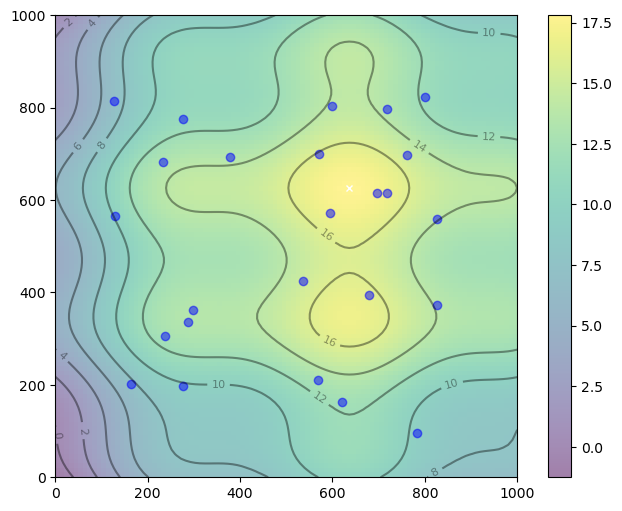

In [100]:
# Plotting - no Animation
x, y = np.array(np.meshgrid(np.linspace(0, dims, 100), np.linspace(0, dims, 100)))
z = fitness_function(x, y)
x_max, y_max = x.ravel()[z.argmax()], y.ravel()[z.argmax()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_max], [y_max], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

i = 10
ax.clear()
ax.imshow(z, extent=[0, dims, 0, dims], origin='lower', cmap='viridis', alpha=0.5)
ax.plot([x_max], [y_max], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
x_list = []
y_list = []
for j in range(num_worms):
    x_list.append(all_positions[j][i][0])
    y_list.append(all_positions[j][i][1])
p_plot = ax.scatter(x_list, y_list, marker='o', color='blue', alpha=0.5)
plt.show()